## Binary Logistics Regression

**Import Relevant Libraries for Data Analysis** 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Read csv data file, white wine in data frame. File has headers and are separated by semicolon ";"

In [2]:
urlw='../Resources/winequality-white.csv'
dfw = pd.read_csv(urlw, sep=';')

In [3]:
dfw.info() # overview of white wine data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


There are 4898 records and 13 columns (12 inputs and 1 output: quality) in the white wine data frame, most of the data are float type with quality and color as integer and object/string. There are no missing values.

In [4]:
dfw.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### In order to use Binary Logistics Model, reclassify wine quality ranking (1 to 10) in to a binary class of premium wine (1) and economy wine (0):###

* Quality score <= 5: Economy Wine
* Quality score >= 6: Premium Wine


In [5]:
cutoff=6
dfw['quality_binary']= dfw['quality'].apply(lambda x: 1 if (x >= cutoff) else 0)

## Checking Logistic regression conditions###

There are two key conditions for fitting a logistic regression model:

* Logistic regression requires the observations to be independent of each other (same as its underlying Binomial distribution).
Given relatively large number of samples this is a reasonable assumption in our case. We will revisit this condition for Training data set below.


* Logistic regression requires there to be little or no multicollinearity among the independent variables. 
To test this, we look at correlation values and it heat map between various predictors. To decide whether (absolute value of) a correlation is "too high", we will use a cut-off value of abs(r)>= 0.7 borrowed from multiple-linear regression model and its  cut-off value for Variance Inflation Factor VIF=1/(1-r^2), between 2 to 5, to indicate significant collinearity between two predictors. In such case, one of the two predictor should be removed from the model.


Text(0.5, 1.0, 'Correlations heatmap for White wine abs(corr)>=0.7')

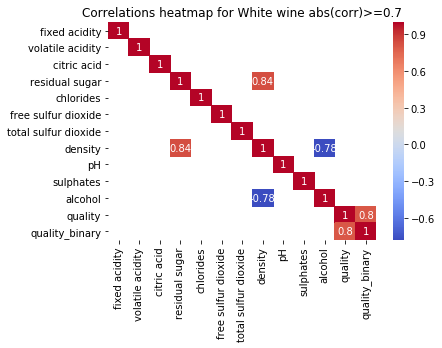

In [6]:
dfwcorr=dfw.corr()
sns.heatmap(dfwcorr[(dfwcorr<=-0.7) | (dfwcorr>=0.7)], cmap='coolwarm', annot=True)
plt.title('Correlations heatmap for White wine abs(corr)>=0.7')

Density has a correlation of +0.84 with residual sugar and -0.78 with alcohol. This is consistent with physical law of mixtures for density where residual sugar (heavier than water) increases density and alcohol that is lighter than water decreases density. Hence Density is a redundant predictor and it will be removed from the model.

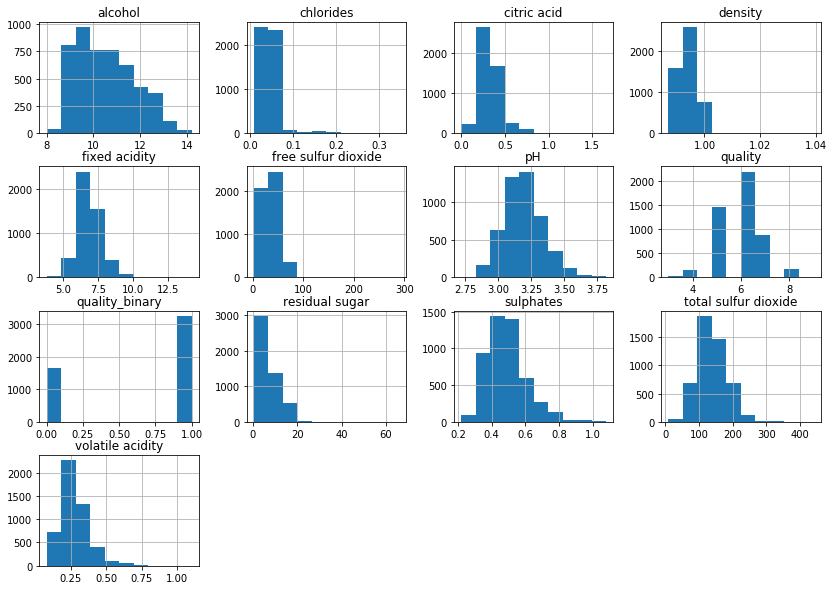

In [7]:
dfw.hist(figsize=(14,10));
plt.show()

The distribution for chlorides, free sulfur dioxide, and residual sugar appears skewed and hence are candidate for log transformation to obtain a distribution that is more normal (improves model performance).

In [8]:
# The distribution for the following predictors appears as skewed and hence are candidate for log transformation
# to obtain a distribution that is more normal (improves model performance)

dfw['log_free sulfur dioxide']=np.log(dfw['free sulfur dioxide'])
dfw['log_chlorides']=np.log(dfw['chlorides'])
dfw['log_residual sugar']=np.log(dfw['residual sugar'])

dfw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_binary,log_free sulfur dioxide,log_chlorides,log_residual sugar
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1,3.806662,-3.101093,3.030134
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,2.639057,-3.015935,0.470004
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,3.401197,-2.995732,1.931521
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,3.850148,-2.847312,2.140066
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,3.850148,-2.847312,2.140066


In [9]:
# list of predictors before removing Density
predictors=list(dfw.columns)[:-5]+list(dfw.columns)[-3:]
predictors

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'log_free sulfur dioxide',
 'log_chlorides',
 'log_residual sugar']

In [10]:
# list of predictors after removing Density
predictors.remove('density')
predictors.remove('chlorides')
predictors.remove('free sulfur dioxide')
predictors.remove('residual sugar')

predictors

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol',
 'log_free sulfur dioxide',
 'log_chlorides',
 'log_residual sugar']

In [11]:
# Splitting the dataset into the Training set and Test set

split_ratio=0.3

X= dfw[predictors]
Y= dfw['quality_binary']
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = split_ratio, random_state = 0) 

In [12]:
dfw_Train= pd.concat([X_Train, Y_Train], axis=1, sort=False)
dfw_Train.head()

,fixed acidity,volatile acidity,citric acid,total sulfur dioxide,pH,sulphates,alcohol,log_free sulfur dioxide,log_chlorides,log_residual sugar,quality_binary
196,6.4,0.29,0.44,183.0,3.01,0.38,9.1,4.317488,-1.624552,1.280934,0
4552,6.4,0.55,0.26,104.0,3.22,0.73,13.1,2.995732,-3.611918,2.261763,1
133,6.6,0.24,0.27,188.0,3.24,0.51,9.2,3.828641,-3.352407,2.760010,0
2517,7.3,0.51,0.29,224.0,3.14,0.56,9.5,4.110874,-3.381395,2.424803,1
3034,6.9,0.25,0.47,156.0,3.15,0.55,9.4,3.583519,-3.170086,2.128232,1


In [13]:
#Test data set
dfw_Test= pd.concat([X_Test, Y_Test], axis=1, sort=False)
dfw_Test.head()

,fixed acidity,volatile acidity,citric acid,total sulfur dioxide,pH,sulphates,alcohol,log_free sulfur dioxide,log_chlorides,log_residual sugar,quality_binary
2762,7.3,0.32,0.35,163.0,3.24,0.42,10.7,2.079442,-2.995732,0.336472,0
42,7.0,0.31,0.26,160.0,3.13,0.46,9.8,3.332205,-2.673649,2.001480,1
1419,7.6,0.14,0.74,103.0,3.07,0.40,10.8,3.295837,-3.218876,0.470004,1
3664,5.0,0.29,0.54,155.0,3.27,0.34,12.9,3.988984,-3.352407,1.740466,1
2125,6.0,0.28,0.22,163.0,3.20,0.46,10.1,3.737670,-3.036554,2.497329,0


In [14]:
# check number of positive and negative responses in the Traning data set
dfw_Train.groupby("quality_binary").count()[['fixed acidity']].rename(columns = {"fixed acidity": "Count"})

,Count
quality_binary,
0,1113
1,2315


In [15]:
# check number of positive and negative responses in the Test data set
dfw_Test.groupby("quality_binary").count()[['fixed acidity']].rename(columns = {"fixed acidity": "Count"})

,Count
quality_binary,
0,527
1,943


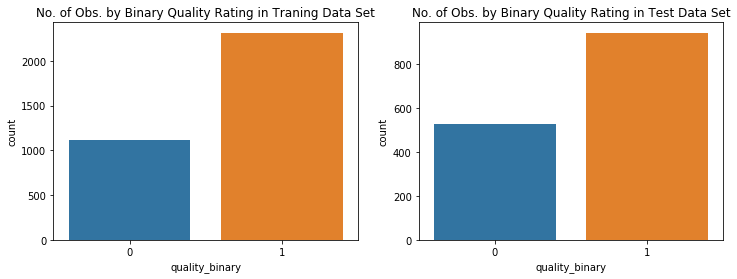

In [16]:
# check number of positive and negative responses in the Traning data set
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x="quality_binary", data=dfw_Train, ax=ax[0])
ax[0].set(title="No. of Obs. by Binary Quality Rating in Traning Data Set");
sns.countplot(x="quality_binary", data=dfw_Test, ax=ax[1])
ax[1].set(title="No. of Obs. by Binary Quality Rating in Test Data Set");

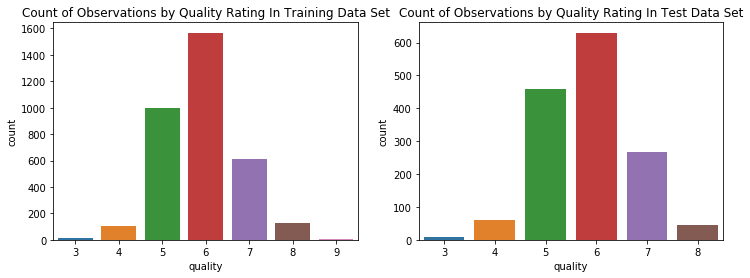

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x="quality", data=dfw.iloc[dfw_Train.index], ax=ax[0]);
ax[0].set(title="Count of Observations by Quality Rating In Training Data Set");
sns.countplot(x="quality", data=dfw.iloc[dfw_Test.index], ax=ax[1]);
ax[1].set(title="Count of Observations by Quality Rating In Test Data Set");

### Train and Test Data Set Alignment###

As seen from above graphs, ratio of number of premium to economy wine in training data set (2.1= 2315 / 1113) and that in the test data set (1.8=943/527) are about the same. Also histogram of quality rankings (1 to 10) of what makes up the premium (>5) or economy (<=5) wine in the training and test data sets are about the same. Hence Training and Test data set are aligned (similar profile as stratified sampling / splitting of the data).

### Checking Balanced Training Data ###

Logistic regression models perform better when the data is balanced, meaning the number of positive instances should be comparable to the number of negative instances. In the Train dataframe, there are approximately twice as many observations with positive value as those with negative target. 
For strongly unbalanced training datasets, we can:

* Reduce the overrepresented class, by shuffling its rows and selecting n rows so that the two datasets - positive and negative classes will have comparable sizes.
* Inflate the underrepresented class, by duplicating entries randomly so that the final dataset has an approximately equal number of positive and negative instances.
* Another approach is to stratify the dataset that is to fetch randomly selected observations from each subclass and compose a new smaller dataset where both classes are equally represented.

**However, in our case, this difference is not too high, so we can proceed with unmodified dataset.**


### Checking Logistic regression conditions in Train data Set###

There are two key conditions for fitting a logistic regression model:

* Each predictor xi is linearly related to logit(pi) if all other predictors are held constant.
While we can plot each predictor xi against logit(pi), we do not have sufficiently large data set to ensure that all other predictors are held constant. We assume this condition holds.


* Each outcome Yi is independent of the other outcomes.
For logistics regression, same as its underlying Binomial distribution, trials must be independent, given relatively large number of samples in each group of training set (1,113 and 2,315) this is a reasonable assumption.

In [18]:
# Fit the model first iterration
mw = Logit(dfw_Train['quality_binary'], dfw_Train[predictors])
mw = mw.fit()

Optimization terminated successfully.
         Current function value: 0.497858
         Iterations 6


In [19]:
print(mw.summary2())

                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.210      
Dependent Variable:   quality_binary     AIC:                3433.3179  
Date:                 2019-12-03 12:34   BIC:                3494.7152  
No. Observations:     3428               Log-Likelihood:     -1706.7    
Df Model:             9                  LL-Null:            -2160.8    
Df Residuals:         3418               LLR p-value:        9.8921e-190
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       6.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
fixed acidity           -0.3915   0.0483  -8.1075 0.0000 -0.4862 -0.2969
volatile acidity        -6.7820   0.4850 -13.9843 0.0000 -7.7325 -5.8314
citric 

 ## Interpreting Regression Summary Output Table
 
 * **Converged** indicates the solver (default is Newton method) converged successfully. 
  
 * **No. Iterations** it took 6 iterations for the solver to find the solution.
  
 * **Pseudo R-squared** is one of the model quality measurement, is a modest 21%. 
  
 * **LLR P-value** p-value for log-likelihood of the null model, since it is nearly zero (less than 0.05) we reject the null hypothesis that of model without predictors, where $\text{logit}(p) = \beta_0$. Hence we consider the model significant.
  
 * **P > $|$z$|$** - is the p-value for **z-statistic** associated with the given parameter, i.e. the probability that the true value of the given regression parameter is equal to the null value zero, given the set of observations. Except for citric acid and chloride, p-values for remaining predictors are less than 0.05; hence they are statistically significant.


In [20]:
# In second iteration of the model remove predictors that were not statistically significant in first iteration
predictors.remove('citric acid')
predictors.remove('log_chlorides')
predictors

['fixed acidity',
 'volatile acidity',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol',
 'log_free sulfur dioxide',
 'log_residual sugar']

In [21]:
# Fit the model second iteration
mw = Logit(dfw_Train['quality_binary'], dfw_Train[predictors])
mw = mw.fit()
print(mw.summary2())

Optimization terminated successfully.
         Current function value: 0.498172
         Iterations 6
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.210      
Dependent Variable:   quality_binary     AIC:                3431.4686  
Date:                 2019-12-03 12:34   BIC:                3480.5865  
No. Observations:     3428               Log-Likelihood:     -1707.7    
Df Model:             7                  LL-Null:            -2160.8    
Df Residuals:         3420               LLR p-value:        2.2164e-191
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       6.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
fixed acidity           -0.4137   0.0451  -9.1685 0

**All p-value for remaining predictors are less than 0.05; hence are statistically significant, without much change to overall model performance based on Pseudo R-squared or AIC & BIC values.** 

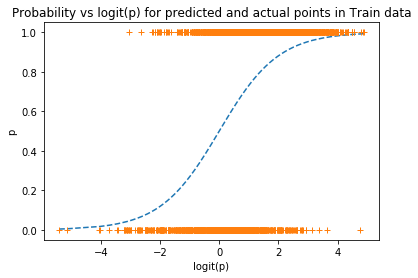

In [22]:
dfw_Train.loc[:, 'p'] = mw.predict(dfw_Train[predictors])
dfw_Train = dfw_Train.sort_values(by = ['p'], axis = 0)
plt.plot(logit(dfw_Train.p), dfw_Train.p, '--')
plt.plot(logit(dfw_Train.p), dfw_Train.quality_binary, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.title('Probability vs logit(p) for predicted and actual points in Train data')
plt.show()

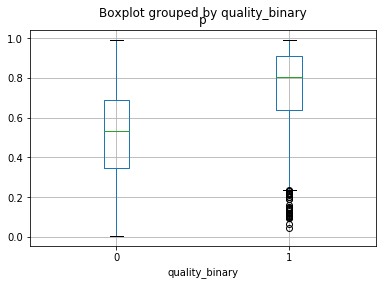

In [23]:
#Box plot for predicted probabilities vs actual response for points in Train data
dfw_Train.boxplot(column='p', by = 'quality_binary')
plt.show();

In [24]:
ths_default=0.5
conf_mat = mw.pred_table(threshold=ths_default)
tn_Train_default, fp_Train_default, fn_Train_default, tp_Train_default = conf_mat.flatten()

In [25]:
acc_Train_default = (tp_Train_default + tn_Train_default) / (tn_Train_default+fp_Train_default+fn_Train_default+tp_Train_default)
print ("Accuracy of the model based on Train data using default threshold of %1.1f is: %1.4f" % (ths_default,acc_Train_default))

Accuracy of the model based on Train data using default threshold of 0.5 is: 0.7538


In [26]:
mcc_Train_default = (tp_Train_default * tn_Train_default - fp_Train_default * fn_Train_default)/\
np.sqrt((tp_Train_default + fp_Train_default)*(tp_Train_default + fn_Train_default)*\
(tn_Train_default + fp_Train_default)*(tn_Train_default + fn_Train_default))

print ("Mathews correlation coefficient, more robust against unbalanced binary response,\
\nbetween the estimates and the true response based on default threshold of %1.1f with Train data is: %1.4f" % (ths_default,mcc_Train_default))

Mathews correlation coefficient, more robust against unbalanced binary response,
between the estimates and the true response based on default threshold of 0.5 with Train data is: 0.4002


In [27]:
prc_Train_default = tp_Train_default / (tp_Train_default + fp_Train_default)
rec_Train_default = tp_Train_default / (tp_Train_default + fn_Train_default)

print ("Model's precision, fraction of correct estimates of all Predicted positives, based on default threshold of %1.1f\n\
with Train data is: %1.4f" % (ths_default,prc_Train_default))
print()
print ("Model's recall/sensitivity, fraction of correct estimates of True positives, based on default threshold of %1.1f\n\
with Train data is: %1.4f" % (ths_default,rec_Train_default))

Model's precision, fraction of correct estimates of all Predicted positives, based on default threshold of 0.5
with Train data is: 0.7737

Model's recall/sensitivity, fraction of correct estimates of True positives, based on default threshold of 0.5
with Train data is: 0.8981


## Tune Threshold value based on Training Set before evaluating model using Test data

In [28]:
# Set discrimination thresholds, create ROC dataframe
ths = np.arange(0., 1.0, 0.01)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []
precision=[]

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = mw.pred_table(threshold=th)
    
    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()
    
    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp) 
    prc  = (1. * tp) / (tp + fp)
    
    
    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)
    precision.append(prc)

In [29]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr' : ths, 
                    'sensitivity' : sensitivity, 
                    'specificity' : specificity,
                    'precision' : precision,
                    '_specificity' : [1 - x for x in specificity],
                    'accuracy' : accuracy, 
                    'matthews' : matthews})

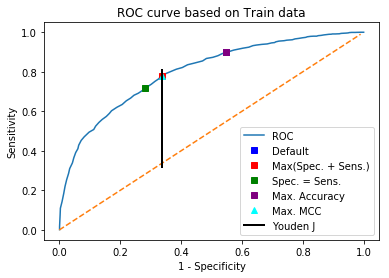

In [30]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

 # Ballanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')


idx_maxmcc = np.argmax(roc.matthews)
x=roc.iloc[idx_maxmcc]._specificity
ymin=x
ymax=roc.iloc[idx_maxmcc].sensitivity

plt.axvline(x=x, ymin=ymin, ymax=ymax,linewidth=2, color='black',label = 'Youden J') # show the line for Youden's J.

plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve based on Train data')
plt.show();

As can be seen from above graph, the ROC point of maximum accuracy is far from **error-free point** (0,1). 
The ROC point of balanced sensitivity and specificity differs from both maximal accuracy and maximal MCC. 
The maximal MCC is identical to maximum of the sum of specificity and sensitivity. This point on the ROC curve is closest to the **error-free point** (0,1) and its corresponding threshold value is often considered to be the **optimal threshold**. The vertical distance between this point and the identity line is called **Youden's J**.

In [31]:
J = max(roc.sensitivity + roc.specificity - 1)
print ('Youden\'s J based on Train data is: %1.4f' % J)

Youden's J based on Train data is: 0.4450


In [32]:
# Sort by 1 - specificity so that area is calculated properly (otherwise we get negative values for area!)
roc2=roc.copy()
roc2 = roc2.sort_values(by = "_specificity")
auc = np.trapz(y = roc2.sensitivity, x = roc2._specificity)
print ("Area under ROC curve based on Train data is: %1.4f" % auc)

Area under ROC curve based on Train data is: 0.7998


Area under the receiver operating characteristics curve (AUC) is the probability that a model will estimate a randomly chosen binary response better than a random estimator. The greater the AUC value, the better the model. 

* A model whose estimates are generated at random is expected to result in $\text{AUC} = 0.5$ (area under the identity line).
* A model that produces the $\text{AUC} < 0.5$ performs worse than a random estimator.
  
AUC's advantage is that it is independent of the particular choice of discrimination threshold and evaluates the model's overall capacity to discriminate between positive and negative responses across all possible thresholds.

Since AUC>0.5 model performs better than a random estimator, next we investigate optimum threshold value.

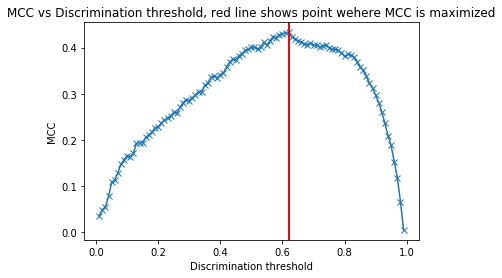

In [33]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')

idx_maxmcc = np.argmax(roc.matthews)
ths_maxmcc=roc.iloc[idx_maxmcc].discret_thr
plt.axvline(ths_maxmcc, linewidth=2, color='r') # show the value of threshold where MCC is maximized with a red line

plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.title('MCC vs Discrimination threshold, red line shows point wehere MCC is maximized')
plt.show()

In [34]:
print ('MCC is maximized at threshold value of %1.2f' % ths_maxmcc)

MCC is maximized at threshold value of 0.62


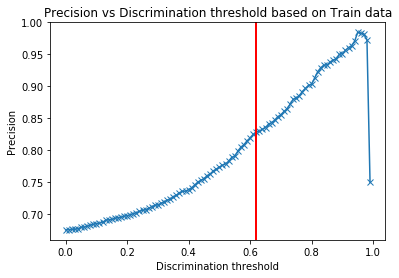

In [35]:
plt.plot(roc.discret_thr, roc.precision, 'x-')
plt.axvline(ths_maxmcc, linewidth=2, color='r') # show the value of threshold where MCC is maximized with a red line
plt.xlabel('Discrimination threshold')
plt.ylabel('Precision')
plt.title('Precision vs Discrimination threshold based on Train data')
plt.show()

In [36]:
prc_maxmcc=roc.iloc[idx_maxmcc].precision
print ('Precision at point where MCC is maximized with a threshold value of %1.2f is: %1.4f' % (ths_maxmcc,prc_maxmcc))

Precision at point where MCC is maximized with a threshold value of 0.62 is: 0.8286


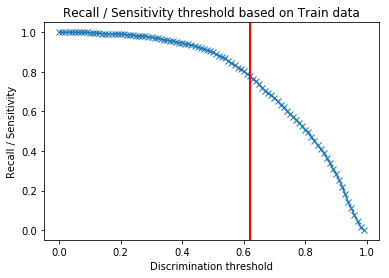

In [37]:
plt.plot(roc.discret_thr, roc.sensitivity, 'x-')
plt.axvline(ths_maxmcc, linewidth=2, color='r') # show the value of threshold where MCC is maximized with a red line
plt.xlabel('Discrimination threshold')
plt.ylabel('Recall / Sensitivity')
plt.title('Recall / Sensitivity threshold based on Train data')
plt.show()

In [38]:
rec_maxmcc=roc.iloc[idx_maxmcc].sensitivity
print ('Recall / Sensitivity at point where MCC is maximized with a threshold value of %1.2f is: %1.4f' % (ths_maxmcc,rec_maxmcc))

Recall / Sensitivity at point where MCC is maximized with a threshold value of 0.62 is: 0.7810


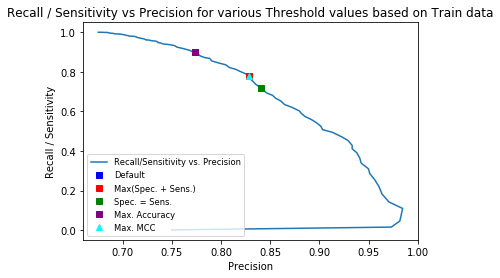

In [39]:
plt.plot(roc.precision, roc.sensitivity, label = 'Recall/Sensitivity vs. Precision')


plt.plot(roc.precision[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc.precision[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot( roc.precision[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot( roc.precision[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot( roc.precision[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')

plt.legend(loc = 3, ncol=1, fontsize = 'small')

plt.xlabel('Precision')
plt.ylabel('Recall / Sensitivity')
plt.title('Recall / Sensitivity vs Precision for various Threshold values based on Train data') 
plt.show();

The wine maker has to balance the risk of a false positive (wine predicted as premium but in truth it is an economy wine), with higher precision in order to avoid disappointing customers and possibly loss of brand equity with the risk of a false negative (wine predicted as economy but in truth it is a premium wine), with higher recall/sensitivity in order to minimize loss of revenue and profit (may lead to higher volume and more customers in the economy segment).

As seen from graphs above model's precision, fraction of correct estimates of all predicted positives, increases with threshold value while recall/sensitivity, fraction of correct estimates of true positives, decreases. The Max (Spec. + Sens.) Youden's J criteria on the ROC curve seems to optimize the mentioned  trade-off. Hence value of threshold value based on this criteria is used as final (replacing default value of 0.5) for the model and its performance valuation using test data.

In [40]:
ths_final=roc.discret_thr[idx_youdensj]
print ('Select final threshold value based on Max(Spec. + Sens.) criteria: %1.2f:'%(ths_final))

Select final threshold value based on Max(Spec. + Sens.) criteria: 0.62:


In [41]:
ths_final=roc.discret_thr[idx_youdensj]
conf_mat = mw.pred_table(threshold=ths_final)
tn_Train_final, fp_Train_final, fn_Train_final, tp_Train_final = conf_mat.flatten()

In [42]:
acc_Train_final = (tp_Train_final + tn_Train_final) / (tn_Train_final+fp_Train_final+fn_Train_final+tp_Train_final)
print ("Accuracy of the model based on Train data using final threshold of %1.2f is: %1.4f" % (ths_final,acc_Train_final))

Accuracy of the model based on Train data using final threshold of 0.62 is: 0.7430


In [43]:
mcc_Train_final = (tp_Train_final * tn_Train_final - fp_Train_final * fn_Train_final)/\
np.sqrt((tp_Train_final + fp_Train_final)*(tp_Train_final + fn_Train_final)*\
(tn_Train_final + fp_Train_final)*(tn_Train_final + fn_Train_final))

print ("Mathews correlation coefficient, more robust against unbalanced binary response,\
\nbetween the estimates and the true response based on final threshold of %1.2f with Train data is: %1.4f" % (ths_final,mcc_Train_final))

Mathews correlation coefficient, more robust against unbalanced binary response,
between the estimates and the true response based on final threshold of 0.62 with Train data is: 0.4332


In [44]:
prc_Train_final = tp_Train_final / (tp_Train_final + fp_Train_final)
rec_Train_final = tp_Train_final / (tp_Train_final + fn_Train_final)

print ("Model's precision, fraction of correct estimates of all Predicted positives, based on final threshold of %1.2f\n\
with Train data is: %1.4f" % (ths_final,prc_Train_final))
print()
print ("Model's recall/sensitivity, fraction of correct estimates of True positives, based on final threshold of %1.2f\n\
with Train data is: %1.4f" % (ths_final,rec_Train_final))

Model's precision, fraction of correct estimates of all Predicted positives, based on final threshold of 0.62
with Train data is: 0.8286

Model's recall/sensitivity, fraction of correct estimates of True positives, based on final threshold of 0.62
with Train data is: 0.7810


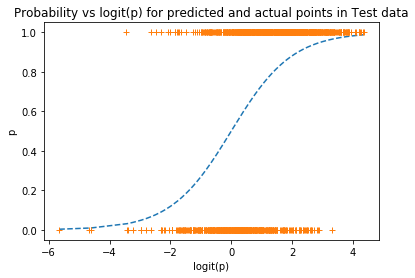

In [45]:
dfw_Test.loc[:, 'p'] = mw.predict(dfw_Test[predictors])
dfw_Test = dfw_Test.sort_values(by = ['p'], axis = 0)
plt.plot(logit(dfw_Test.p), dfw_Test.p, '--')
plt.plot(logit(dfw_Test.p), dfw_Test.quality_binary, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.title('Probability vs logit(p) for predicted and actual points in Test data')
plt.show()

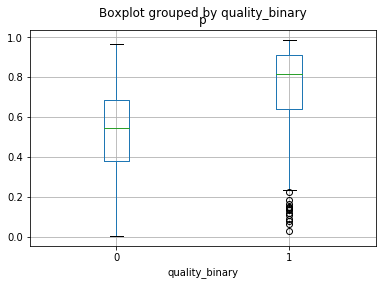

In [46]:
# Box plot for predicted probabilities vs actual response for points in Test data
dfw_Test.boxplot(column='p', by = 'quality_binary')
plt.show()

In [47]:
dfw_Test.loc[:, 'yhat'] = (dfw_Test.p > ths_final) * 1
pd.crosstab(dfw_Test.quality_binary, dfw_Test.yhat)

yhat,0,1
quality_binary,,
0,340,187
1,212,731


In [48]:
tn_Test=pd.crosstab(dfw_Test.quality_binary, dfw_Test.yhat).iloc[0, 0]
fp_Test=pd.crosstab(dfw_Test.quality_binary, dfw_Test.yhat).iloc[0, 1]
fn_Test=pd.crosstab(dfw_Test.quality_binary, dfw_Test.yhat).iloc[1, 0]
tp_Test=pd.crosstab(dfw_Test.quality_binary, dfw_Test.yhat).iloc[1, 1]

In [49]:
acc_Test = (tp_Test + tn_Test) / (tn_Test+fp_Test+fn_Test+tp_Test)
print ("Accuraccy of the model based on final threshold of %1.2f for Test data is: %1.4f" % (ths_final, acc_Test))

Accuraccy of the model based on final threshold of 0.62 for Test data is: 0.7286


In [50]:
mcc_Test = (tp_Test * tn_Test - fp_Test * fn_Test)/np.sqrt((tp_Test + fp_Test)*(tp_Test + fn_Test)*\
                                                           (tn_Test + fp_Test)*(tn_Test + fn_Test))
print ("Mathews correlation coefficient, more robust against unbalanced binary response,\
\nbetween the estimates and the true response with final threshold of %1.2f for Test data is: %1.4f" % (ths_final, mcc_Test))

Mathews correlation coefficient, more robust against unbalanced binary response,
between the estimates and the true response with final threshold of 0.62 for Test data is: 0.4163


In [51]:
prc_Test = tp_Test / (tp_Test + fp_Test)
rec_Test = tp_Test / (tp_Test + fn_Test)
print ("Model's precision, fraction of correct estimates of all Predicted positives,with final threshold of %1.2f\n\
for Test data is: %1.4f" % (ths_final,prc_Test))
print()
print ("Model's recall/sensitivity, fraction of correct estimates of True positives, with final threshold of %1.2f\n\
for Test data is %1.4f" % (ths_final,rec_Test))

Model's precision, fraction of correct estimates of all Predicted positives,with final threshold of 0.62
for Test data is: 0.7963

Model's recall/sensitivity, fraction of correct estimates of True positives, with final threshold of 0.62
for Test data is 0.7752


In [52]:
print ("Data     Threshold  Precision  Recall    ACC     MCC")
print( "Train    %1.2f       %1.3f      %1.3f     %1.3f   %1.3f " %(ths_default,prc_Train_default,rec_Train_default,acc_Train_default,mcc_Train_default))
print( "Train    %1.2f       %1.3f      %1.3f     %1.3f   %1.3f " %(ths_final,prc_Train_final,rec_Train_final,acc_Train_final,mcc_Train_final))
print( "Test     %1.2f       %1.3f      %1.3f     %1.3f   %1.3f " %(ths_final,prc_Test,rec_Test,acc_Test,mcc_Test))

Data     Threshold  Precision  Recall    ACC     MCC
Train    0.50       0.774      0.898     0.754   0.400 
Train    0.62       0.829      0.781     0.743   0.433 
Test     0.62       0.796      0.775     0.729   0.416 


## Summary

* In order to use Binary Logistics Model, wine quality ranking (1 to 10) were reclassify in to a binary class of premium wine (1) and economy wine (0)


* Logistic regression condition for observations to be independent of each other is assumed to be reasonable.


* Logistic regression condition that there to be little or no multicollinearity among the independent variables was not initially met. Based on analysis of correlations among various predictors. Density was removed from list of predictors to satisfy the multicollinearity condition.


* Chlorides, free sulfur dioxide, and residual sugar were transformed using log transformation to obtain a more normal distribution and in turn improves model performance. Data was split between Training and Test set using 30% as the split ratio


* Balance of data points with positive and negative response in Training data set was deemed adequate, 3 options to improve balance for future studies was recommended.


* First iteration of Binary Logistics Regression model was fit to Training data. Two predictors, citric acid and chlorides, with p-values greater than 0.05; statistically not significant, were removed from list of predictors.


* Second iteration of the model was fit to Training data with the remaining predictors. All p-values were less than 0.05; hence predictors were statistically significant, without much change to overall model performance based on Pseudo R-squared or AIC & BIC values (compared to first iteration).


* The default threshold value (0.5) was tuned using Training data set and ROC curve (before evaluating model using Test data).The maximal MCC, identical to maximum of the sum of specificity and sensitivity, was the closest point to the **error-free point** (0,1) and its corresponding threshold value was selected as the **optimal threshold** (0.62).


* The selected optimal threshold value also strike a balance between the risks of false positive (wine predicted as premium wine but in truth it is an economy wine. This could lead to a disappointed customers and loss of brand equity) and risk of a false negative (wine predicted as economy but in truth it is a premium wine. This could lead to loss of revenue and profit).


* Model performance, with optimal threshold value, was evaluated using Test data set. Metrics, including Precision, Recall, ACC and MCC, were comparable to those from Train data set (also with optimal threshold value).


* While wine maker can explore more advanced models (with possibly higher performance), the final Binary Logistics Model is "adequate" to predict wine classification: premium versus economy wine, based on selected predictors.